In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings("ignore")

In [5]:
# Get data
df = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv")

# Initial Data Display
df.head(10)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True
5,https://www.brookings.edu/interactives/reopeni...,False
6,https://www.reuters.com/investigates/special-r...,False
7,https://www.theatlantic.com/magazine/archive/2...,False
8,https://www.vox.com/2020/6/17/21294680/john-bo...,False
9,https://www.theguardian.com/travel/2020/jun/18...,False


In [6]:
df.shape


(2999, 2)

In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


In [8]:
duplicates = df.duplicated().sum()
print(duplicates)

df = df.drop_duplicates()


630


In [9]:
df.shape


(2369, 2)

is_spam
False    2125
True      244
Name: count, dtype: int64


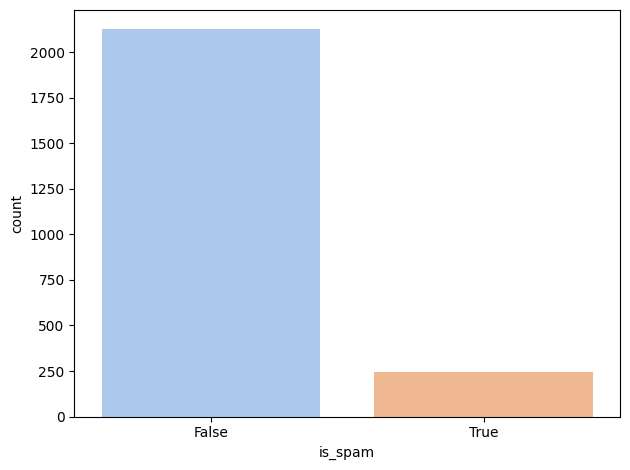

In [10]:
print(df["is_spam"].value_counts())


sns.countplot(data = df, x = "is_spam", palette='pastel', hue= "is_spam", legend=False)
# Adjust the Layout
plt.tight_layout()
# Display the Plot
plt.show()

In [11]:
# Text preprocessing
def clean_url(texto):
    cleaned = texto.lower()
    # Remove http and https
    cleaned = re.sub(r'https?://', ' ', cleaned)
    # Replace uninformative symbols with spaces
    cleaned = re.sub(r'[#?=&%_+:;]', ' ', cleaned)
    # Replace periods, slashes, and dashes with spaces
    cleaned = re.sub(r'[./-]', ' ', cleaned)
    # Replace domain values ​​with space
    cleaned = re.sub(r'\b(?:www|com|org|net|io|gov|edu|xyz|es)\b', ' ', cleaned)
    # Delete isolated numbers (but not those within words)
    cleaned = re.sub(r'\b\d+\b', ' ', cleaned)
    # Delete single-letter words
    cleaned = re.sub(r'\b[a-zA-Z]\b', ' ', cleaned)

    return cleaned.split()

In [ ]:
df["url"] = df["url"].apply(clean_url)
df.head(10)

,url,is_spam
0,"[briefingday, us8, list, manage, unsubscribe]",True
1,[hvper],True
2,"[briefingday, v4n3i4f3]",True
3,"[briefingday, commentform]",False
4,"[briefingday, fan]",True
5,"[brookings, interactives, reopening, america, ...",False
6,"[reuters, investigates, special, report, healt...",False
7,"[theatlantic, magazine, archive, supermarkets,...",False
8,"[vox, john, bolton, book, excerpts, trump, ukr...",False
9,"[theguardian, travel, jun, end, of, tourism, c...",False


In [15]:
# Text processing
import re
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Instantiate lemmatizer
download("wordnet")
lemmatizer = WordNetLemmatizer()

download("stopwords")
stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in words]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Keeps those longer than 3
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
df["url"] = df["url"].apply(lemmatize_text)
df.head(10)

,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",True
1,[hvper],True
2,"[briefingday, v4n3i4f3]",True
3,"[briefingday, commentform]",False
4,[briefingday],True
5,"[brookings, interactives, reopening, america, ...",False
6,"[reuters, investigates, special, report, healt...",False
7,"[theatlantic, magazine, archive, supermarket, ...",False
8,"[john, bolton, book, excerpt, trump, ukraine, ...",False
9,"[theguardian, travel, tourism, coronavirus, pa...",False


In [17]:
# Separate by classes
df_pos = df[df['is_spam'] == True]
df_neg = df[df['is_spam'] == False]

# Balance by resampling the minority
max_size = max(len(df_pos), len(df_neg))
df_pos_bal = resample(df_pos, replace=True, n_samples=max_size, random_state=42)
df_neg_bal = resample(df_neg, replace=True, n_samples=max_size, random_state=42)

# Combine and mix
df_balanced = pd.concat([df_pos_bal, df_neg_bal]).sample(frac=1, random_state=42)

In [18]:
# Separate by classes
df_pos = df[df['is_spam'] == True]
df_neg = df[df['is_spam'] == False]

# Balance by resampling the minority
max_size = max(len(df_pos), len(df_neg))
df_pos_bal = resample(df_pos, replace=True, n_samples=max_size, random_state=42)
df_neg_bal = resample(df_neg, replace=True, n_samples=max_size, random_state=42)

# Combine and mix
df_balanced = pd.concat([df_pos_bal, df_neg_bal]).sample(frac=1, random_state=42)

In [20]:
tokens_list = df_balanced["url"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

vectorizer = TfidfVectorizer(
    analyzer="word",
    ngram_range=(1, 3),
    min_df=1,
    max_df=0.9,               # Ignore tokens that appear in +90% of cases (not very informative)
    token_pattern=r"(?u)\b\w\w+\b",  # Words of at least 2 letters (avoid tokens like 'a', 'b', etc.)
    sublinear_tf=True,        # TF scale in logarithmic form (helps with short texts)
    norm='l2',                # Typical normalization
    lowercase=False
)

X = vectorizer.fit_transform(tokens_list).toarray()
y = df_balanced["is_spam"]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [22]:
model = SVC(
    kernel="linear",
    C=1.0,
    random_state=42
)

model.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [24]:
y_pred = model.predict(X_test)


In [25]:
accuracy_score(y_test, y_pred)


0.9941176470588236

In [26]:
accuracy_test = accuracy_score(y_test, y_pred)
f1_score_test = f1_score(y_test, y_pred)
precision_test = precision_score(y_test, y_pred)
recall_test = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy_test)
print("F1 score: ", f1_score_test)
print("Precision: ", precision_test)
print("Recall: ", recall_test)

Accuracy:  0.9941176470588236
F1 score:  0.9940405244338498
Precision:  0.9952267303102625
Recall:  0.9928571428571429


In [27]:
def predict_spam(new_url):
    # Aplicar preprocesamiento y lematización
    processed_message = clean_url(new_url)
    lemmatized_message = lemmatize_text(processed_message, lemmatizer)

    # Unir tokens en una sola cadena
    lemmatized_message = " ".join(lemmatized_message)

    # Vectorizar utilizando el vectorizador entrenado
    vectorized_message = vectorizer.transform([lemmatized_message]).toarray()

    # Realizar predicción
    prediction = model.predict(vectorized_message)

    # Mostrar resultado
    print(new_url)
    print("Predicción:", "Spam" if prediction[0] == 1 else "No Spam")
    print(50*"-")

In [28]:
probe_urls = [
    "http://account-verify-now.net/auth",                     # True  → spam (login fraudulento disfrazado)
    "http://freeiphonegiveaway.co.uk/enter",                  # True  → spam (promoción falsa muy típica)

    "https://www.ieee.org/publications/index.html",           # False → no spam (dominio educativo legítimo)
    "https://www.oracle.com/security-alerts/",                # False → no spam (empresa tech conocida)
]

In [29]:
for url in probe_urls:
    predict_spam(url)

http://account-verify-now.net/auth
Predicción: Spam
--------------------------------------------------
http://freeiphonegiveaway.co.uk/enter
Predicción: No Spam
--------------------------------------------------
https://www.ieee.org/publications/index.html
Predicción: No Spam
--------------------------------------------------
https://www.oracle.com/security-alerts/
Predicción: No Spam
--------------------------------------------------
